# 텍스트 데이터 분석

In [ ]:
!pip install mlxtend

In [141]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import matplotlib.pyplot as plt
import networkx as nx
from wordcloud import WordCloud
from PIL import Image

In [81]:
plt.rcParams['font.family'] = 'NanumGothic'

## Association Rule
항목 간 관계를 규칙 기반으로 분석하는 방법 <br>
마케팅 등에서 고객 상품 구매 데이터를 활용해 품목 간 연관성을 본다는 의미에서 장바구니 분석이라고도 불림 <br>

<br>

> example <br>
- 삼겹살, 소주 -> 삼겹살을 사는 고객은 소주도 같이 구매한다

<br>

<span style="font-size: 20px;">분석 방법</span>

거래 내역이 아래와 같이 주어져 있다고 가정

|번호|품목|
|-|-|
|1|삼겹살, 상추, 소주|
|2|삼겹살, 소주|
|3|삼겹살, 깻잎|
|4|닭고기, 비누|
|5|닭고기, 상추, 고추|

<br>
<br>

위의 거래 내역을 이용하여 다음의 구매 행렬을 만들 수 있음 <br>

||삼겹살|상추|소주|깻잎|닭고기|비누|고추|
|-|-|-|-|-|-|-|-|
|삼겹살|3|1|2|1|0|0|0
|상추 |1|2|1|0|1|0|1|
|소주|2|1|2|0|0|0|0|
|깻잎|1|0|0|1|0|0|0|
|닭고기|0|1|0|0|2|1|1|
|비누|0|0|0|0|1|1|0|
|고추|0|1|0|0|1|0|1|

<br>
위의 규칙을 보면 삼겹살을 사는 고객은 소주를 산다는 것을 확인할 수 있음 <br>
그러나 이는 정성적이므로, 정량적 평가 지표를 도입하여 이러한 연관 규칙이 유효한지 판단 <br>

1. Confidence <br>
X가 포함하는 거래 내역 중 Y가 포함된 비율이 높아야 함 <br>
$P(소주|삼겹살) = \frac{\frac{2}{5}}{\frac{3}{5}} = \frac{2}{3} $

2. Support <br>
X와 Y를 동시에 포함하는 비율이 높아야 함 $P(X \cap Y)$ <br>
신뢰도 $P(상추|소주) = \frac{\frac{1}{5}}{\frac{2}{5}} = \frac{1}{2} $이나 거래 건수가 5개 중 1개<br>
이는 아직 발생 횟수가 충분하지 않아 소주를 사면 삼겹살을 샀다라는 규칙을 지지하기 위해 실질적으로는 $P(X \cap Y)$가 높아야 함을 의미

3. Lift <br>
신뢰도가 만약 $P(Y|X)=0.8$이었고 이는 충분히 높은 수치라고 판단하여 X -> Y라는 규칙이 의미 있다고 판단 할 수 있을 것 <br>
하지만 Y가 발생한 비율이 0.8이었다고 하면 $P(Y|X) = P(Y)$가 되어 X는 Y를 설명하는데 아무런 도움이 되지 못함 <br>
따라서 P(Y|X)/P(Y)를 계산하는데 이를 향상도(Lift)라고 함 <br>
- Lift = 1: X와 Y는 독립
- Lift > 1: X가 Y 발생 확률을 X를 고려하지 않았을 때보다 증가시킴 (X가 Y 증가 예측에 도움을 줌)
- Lift < 1: X가 Y 발생 확률을 X를 고려하지 않았을 때보다 감소시킴 (X가 Y 감소 예측에 도움을 줌) 

<br>
<br>

```python
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

documents = ['I like apple and also like samsung', 'I like apple watch', 'I do like samsumg smart phone', 'I hate phone']
words = list(itertools.chain(*[document.split() for document in documents]))
items = [words[i:i+3] for i in range(len(words)-3)]

transaction_encoder = TransactionEncoder()
te_result = transaction_encoder.fit(items).transform(items)
data = pd.DataFrame(te_result, columns=np.unique(words))
itemset = apriori(data, min_support=0.5, use_colnames=True)
association_rules(itemset, metric='confidence', min_threshold=0.5)
```

In [2]:
receipts = [
    ['삼겹살', '상추', '소주'],
    ['삼겹살', '소주'],
    ['삼겹살', '깻잎'],
    ['닭고기', '비누'],
    ['닭고기', '상추', '고추'],
]

In [15]:
transaction_encoder = TransactionEncoder()
te_result = transaction_encoder.fit_transform(receipts)
data = pd.DataFrame(te_result, columns=transaction_encoder.columns_)
itemset = apriori(data, min_support=0.4, use_colnames=True)
association_rules(itemset, metric='confidence', min_threshold=0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(소주),(삼겹살),0.4,0.6,0.4,1.000000,1.666667,0.16,inf,0.666667
1,(삼겹살),(소주),0.6,0.4,0.4,0.666667,1.666667,0.16,1.8,1.000000


### 곽튜브

In [18]:
# Kiwi 클래스를 생성하여 'kiwi' 객체를 만듦
kiwi = Kiwi()

# 'kiwi_tokenizer' 함수 정의
# 'contents'는 입력 텍스트, 'stopwords'는 불용어 목록 (optional)
def kiwi_tokenizer(contents, stopwords=None):
    
    # 'contents'를 Kiwi 객체로 토크나이즈(단어 분리)하고, 명사(NNP, NNG)만 추출
    # 'stopwords'를 사용할 수 있으며, 해당 단어들은 제외됨
    tokens = [
        token.form  # 각 토큰의 형태소를 반환 (단어 자체)
        for token
        in kiwi.tokenize(contents, stopwords=stopwords)  # Kiwi 객체를 사용해 토크나이즈 실행
        if token.tag in {'NNP', 'NNG'}  # 추출된 토큰이 고유명사(NNP) 또는 일반명사(NNG)인 경우만 필터링
    ]

    # 최종적으로 명사들로 구성된 리스트를 반환
    return tokens

In [51]:
# 'comments_kwak.pickle' 파일에서 데이터를 읽어와 pandas DataFrame으로 저장
data = pd.read_pickle('./data/comments_kwak.pickle')

# Kiwi 객체 생성
kiwi = Kiwi()

# 사용자 정의 단어를 추가 ('곽튜브'를 고유명사(NNP)로, '학폭'과 '빠니보틀'을 일반명사(NNG)로 추가)
kiwi.add_user_word('곽튜브', 'NNP')
kiwi.add_user_word('학폭', 'NNG')
kiwi.add_user_word('빠니보틀', 'NNG')

# 데이터프레임의 'textOriginal' 열에 있는 각 댓글을 'kiwi_tokenizer' 함수를 사용하여 토크나이즈
# 각 댓글의 명사 토큰을 'tokens' 열에 저장
data['tokens'] = data.textOriginal.apply(lambda x: kiwi_tokenizer(x))

#### no window

In [ ]:
comments = data.tokens.tolist()
comments

In [68]:
# pandas의 출력 옵션 설정: 데이터프레임의 최대 표시 행 수를 150으로 설정
pd.set_option('display.max_rows', 150)

# TransactionEncoder 객체 생성
transaction_encoder = TransactionEncoder()

# comments 데이터를 TransactionEncoder로 변환
# fit_transform은 데이터를 학습하고 변환하는 과정 (True/False로 변환된 2D 배열 생성)
te_result = transaction_encoder.fit_transform(comments)

# 변환된 결과(te_result)를 pandas DataFrame으로 변환
# 열 이름은 변환된 데이터에 있는 항목으로 설정
temp = pd.DataFrame(te_result, columns=transaction_encoder.columns_)

# apriori 알고리즘 적용, 최소 지지도(min_support)를 0.02로 설정하여 자주 발생하는 아이템 집합 추출
itemset = apriori(temp, min_support=0.02, use_colnames=True)

# 연관 규칙을 계산, 신뢰도(confidence)를 기준으로 최소 임계값(min_threshold)은 0.02로 설정
results = association_rules(itemset, metric='confidence', min_threshold=0.02)

# 연관 규칙 결과 출력
results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(학폭),(가해자),0.095989,0.049402,0.026932,0.280576,5.679392,0.022190,1.321331,0.911411
1,(가해자),(학폭),0.049402,0.095989,0.026932,0.545161,5.679392,0.022190,1.987541,0.866744
2,(곽튜브),(사람),0.136149,0.123718,0.032616,0.239563,1.936356,0.015772,1.152339,0.559779
3,(사람),(곽튜브),0.123718,0.136149,0.032616,0.263632,1.936356,0.015772,1.173125,0.551839
4,(영상),(곽튜브),0.074369,0.136149,0.020292,0.272857,2.004111,0.010167,1.188008,0.541280
5,(곽튜브),(영상),0.136149,0.074369,0.020292,0.149044,2.004111,0.010167,1.087754,0.579991
6,(곽튜브),(학폭),0.136149,0.095989,0.023108,0.169723,1.768143,0.010039,1.088806,0.502905
7,(학폭),(곽튜브),0.095989,0.136149,0.023108,0.240730,1.768143,0.010039,1.137740,0.480564
8,(사람),(학폭),0.123718,0.095989,0.024436,0.197510,2.057620,0.012560,1.126507,0.586571
9,(학폭),(사람),0.095989,0.123718,0.024436,0.254566,2.057620,0.012560,1.175531,0.568579


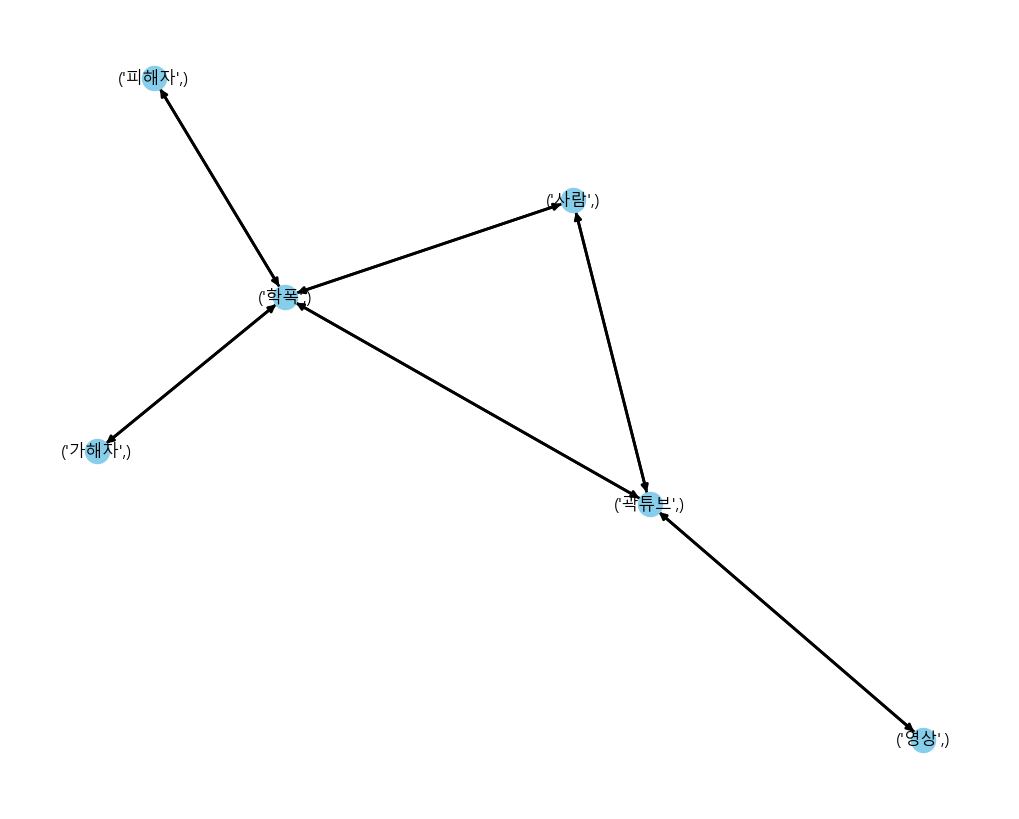

In [90]:
# 빈 방향성 그래프(DiGraph) 객체를 생성
G = nx.DiGraph()

# results 데이터프레임에서 각 연관 규칙을 순회하며 그래프의 간선(edge) 추가
for row in results.itertuples():
    # 선행 항목(antecedents)과 후행 항목(consequents)을 튜플로 변환
    antecedents = tuple(row.antecedents)
    consequents = tuple(row.consequents)

    # 선행 항목에서 후행 항목으로의 간선을 추가하고, 'lift' 값을 가중치로 설정
    G.add_edge(antecedents, consequents, weight=row.lift)

# 각 간선의 가중치(lift)를 추출하여 리스트로 저장
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# 스프링 레이아웃을 사용해 노드의 위치를 계산 (자연스러운 배치)
pos = nx.spring_layout(G)

# 그래프의 크기를 설정
plt.figure(figsize=(10, 8))

# 그래프를 그리기
nx.draw(
    G,                # 그래프 객체
    pos,              # 노드의 위치
    with_labels=True, # 노드에 라벨 표시
    node_color='skyblue',  # 노드 색상
    # edge_color=edge_weights,  # 주석 처리된 부분 (간선 색상을 가중치로 설정하려면 주석 해제)
    width=2.0,        # 간선의 두께
    edge_cmap=plt.cm.Blues,  # 간선 색상 맵 (파란색 계열)
    font_family='Malgun Gothic'  # 한글 폰트 설정 (Malgun Gothic)
)

# 그래프를 화면에 출력
plt.show()

#### window

In [35]:
# 윈도우 사이즈를 5로 설정 (5개의 토큰씩 묶어서 처리)
window_size = 5

# 'tokens' 열에서 각 행의 토큰을 슬라이딩 윈도우로 묶어서 새로운 'window_tokens' 열에 저장
data['window_tokens'] = data.tokens.apply(
    # tokens 리스트에서 마지막 행의 토큰 리스트에 대해 슬라이딩 윈도우 생성
    # 만약 토큰 리스트의 길이가 5보다 크면 슬라이딩 윈도우 적용
    # 길이가 5 이하이면 토큰 리스트 그대로 반환
    lambda x: np.lib.stride_tricks.sliding_window_view(data.tokens.tolist()[-1], window_size) if len(x) > 5 else [x]
)

In [41]:
comments_windowed = list(itertools.chain(*data.window_tokens))

In [48]:
pd.set_option('display.max_rows', 150)

transaction_encoder = TransactionEncoder()
te_result = transaction_encoder.fit_transform(comments_windowed)
data = pd.DataFrame(te_result, columns=transaction_encoder.columns_)
itemset = apriori(data, min_support=0.15, use_colnames=True)
association_rules(itemset, metric='confidence', min_threshold=0.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(동생),(뇌피셜),0.315554,0.315429,0.189258,0.599764,1.901420,0.089723,1.710417,0.692643
1,(뇌피셜),(동생),0.315429,0.315554,0.189258,0.600000,1.901420,0.089723,1.711116,0.692518
2,(뇌피셜),(본인),0.315429,0.379213,0.252344,0.800000,2.109633,0.132729,3.103936,0.768341
3,(본인),(뇌피셜),0.379213,0.315429,0.252344,0.665440,2.109633,0.132729,2.046184,0.847286
4,(부분),(뇌피셜),0.315468,0.315429,0.189258,0.599927,1.901939,0.089750,1.711116,0.692766
5,(뇌피셜),(부분),0.315429,0.315468,0.189258,0.600000,1.901939,0.089750,1.711331,0.692727
6,(부정),(뇌피셜),0.315448,0.315429,0.252344,0.799952,2.536072,0.152842,3.422024,0.884797
7,(뇌피셜),(부정),0.315429,0.315448,0.252344,0.800000,2.536072,0.152842,3.422758,0.884773
8,(댓글),(인생),0.192306,0.253299,0.189286,0.984298,3.885913,0.140575,47.554925,0.919482
9,(인생),(댓글),0.253299,0.192306,0.189286,0.747284,3.885913,0.140575,3.196053,0.994589


### 수정이

In [98]:
comments = pd.read_csv('./data/comments.csv').query('video_id=="JPaubSOSxeM"')
comments['tokens'] = comments.comments.apply(lambda x: kiwi_tokenizer(x))

In [99]:
words = tuple(itertools.chain(*comments.tokens.tolist()))

In [116]:
# 토큰 리스트를 전처리하는 함수 정의
def preprocessing(tokens: list):
    # 입력된 토큰 리스트를 numpy 배열로 변환
    tokens = np.array(tokens)
    
    # 특정 단어를 다른 단어로 치환
    # '아버지' 또는 '아버님'을 '아빠'로 변경
    tokens = np.where((tokens == '아버지') | (tokens == '아버님'), '아빠', tokens)
    # '수정'을 '수정이'로 변경
    tokens = np.where(tokens == '수정', '수정이', tokens)

    # 특정 단어를 빈 문자열로 치환 (제거)
    # '신', '수', '국'은 제거
    tokens = np.where((tokens == '신') | (tokens == '수') | (tokens == '국'), '', tokens)
    
    # 빈 문자열을 가진 토큰 제거
    tokens = tokens[tokens != '']

    # 전처리된 토큰을 반환
    return tokens

In [117]:
# 'comments' 데이터프레임의 'tokens' 열에 대해 전처리 함수(preprocessing)를 적용
comments.tokens = comments.tokens.apply(lambda x: preprocessing(x))

In [126]:
transaction_encoder = TransactionEncoder()
te_result = transaction_encoder.fit_transform(comments.tokens)
temp = pd.DataFrame(te_result, columns=transaction_encoder.columns_)
itemset = apriori(temp, min_support=0.01, use_colnames=True)
results = association_rules(itemset, metric='confidence', min_threshold=0.01)

In [127]:
results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(구독자),(축하),0.018687,0.068258,0.010641,0.569444,8.342469,0.009366,2.164045,0.896891
1,(축하),(구독자),0.068258,0.018687,0.010641,0.155894,8.342469,0.009366,1.162547,0.944609
2,(아빠),(딸),0.076045,0.033221,0.016610,0.218430,6.575085,0.014084,1.236971,0.917697
3,(딸),(아빠),0.033221,0.076045,0.016610,0.500000,6.575085,0.014084,1.847911,0.877047
4,(이세돌),(바둑),0.033480,0.014794,0.010641,0.317829,21.484156,0.010146,1.444223,0.986482
5,(바둑),(이세돌),0.014794,0.033480,0.010641,0.719298,21.484156,0.010146,3.443226,0.967771
6,(이세돌),(알파고),0.033480,0.027771,0.026732,0.798450,28.751648,0.025803,4.823754,0.998655
7,(알파고),(이세돌),0.027771,0.033480,0.026732,0.962617,28.751648,0.025803,25.854399,0.992790


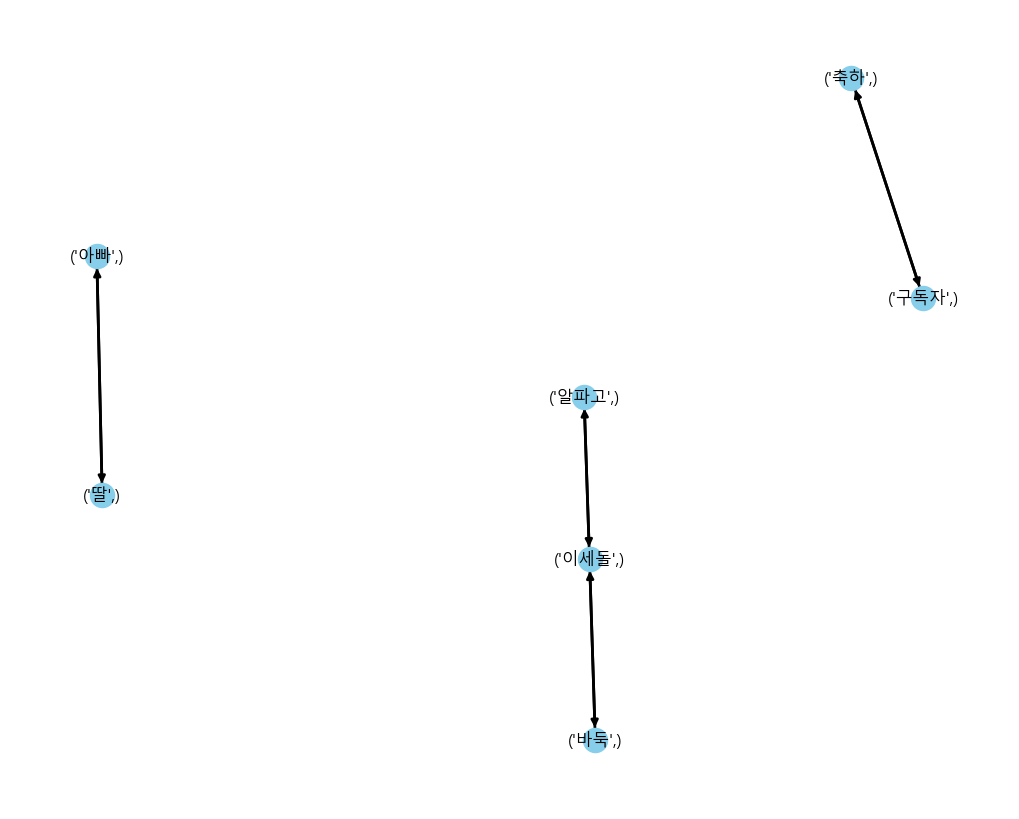

In [128]:
G = nx.DiGraph()

for row in results.itertuples():
    antecedents = tuple(row.antecedents)
    consequents = tuple(row.consequents)

    G.add_edge(antecedents, consequents, weight=row.lift)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
pos = nx.spring_layout(G, k=2)
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    # edge_color=edge_weights,
    width=2.0,
    edge_cmap=plt.cm.Blues,
    font_family='Malgun Gothic'
)
plt.show()

### 민희진

In [132]:
data = pd.read_pickle('./data/comments_minheejin.pickle')

In [134]:
kiwi = Kiwi()
kiwi.add_user_word('빌리프렙', 'NNP')
kiwi.add_user_word('뉴진스', 'NNP')
kiwi.add_user_word('하이브', 'NNP')
kiwi.add_user_word('민희진', 'NNP')
kiwi.add_user_word('국힙', 'NNG')

True

In [135]:
kiwi = Kiwi()

def kiwi_tokenizer(contents, stopwords=None):
    tokens = [
        token.form
        for token
        in kiwi.tokenize(contents, stopwords=stopwords)
        if token.tag in {'NNP', 'NNG', 'VV', 'VA'}
    ]

    return tokens

In [137]:
data['tokens'] = data.textOriginal.apply(lambda x: kiwi_tokenizer(x))
data.tokens = data.tokens.apply(lambda x: [token for token in x if len(token) >= 2])

In [154]:
def preprocessing(tokens: list):
    tokens = np.array(tokens)
    tokens = np.where(tokens=='민희', '민희진', tokens)


    return tokens

In [155]:
data['tokens'] = data.tokens.apply(lambda x: preprocessing(x))

#### wordcloud

(-0.5, 399.5, 199.5, -0.5)

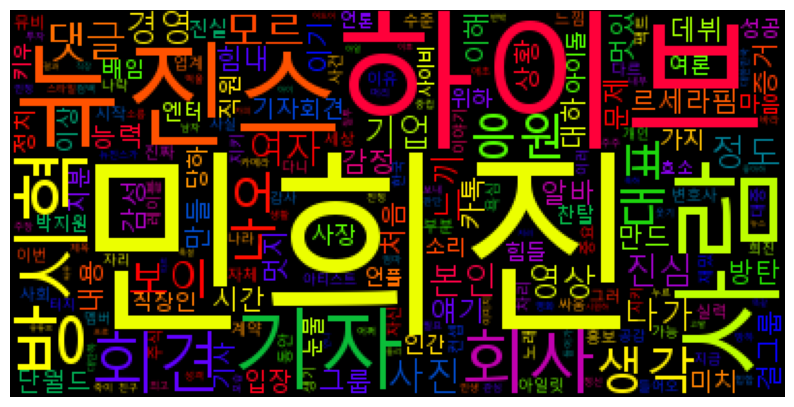

In [157]:
word_cloud = WordCloud(
    font_path='malgun',
    background_color='black',
    max_font_size=100,
    colormap='prism',
).generate_from_frequencies(Counter(itertools.chain(*data.tokens)))

plt.figure(figsize=(10, 8))
plt.imshow(word_cloud)
plt.axis('off')

#### association rule

In [160]:
transaction_encoder = TransactionEncoder()
te_result = transaction_encoder.fit_transform(data.tokens)
temp = pd.DataFrame(te_result, columns=transaction_encoder.columns_)
itemset = apriori(temp, min_support=0.02, use_colnames=True)
results = association_rules(itemset, metric='confidence', min_threshold=0.02)
results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(기자),(민희진),0.096273,0.212214,0.020356,0.211440,0.996356,-0.000074,0.999019,-0.004031
1,(민희진),(기자),0.212214,0.096273,0.020356,0.095922,0.996356,-0.000074,0.999612,-0.004621
2,(회견),(기자),0.050841,0.096273,0.049169,0.967118,10.045580,0.044274,27.483933,0.948686
3,(기자),(회견),0.096273,0.050841,0.049169,0.510725,10.045580,0.044274,1.939931,0.996378
4,(뉴진스),(민희진),0.094011,0.212214,0.044449,0.472803,2.227960,0.024498,1.494293,0.608351
5,(민희진),(뉴진스),0.212214,0.094011,0.044449,0.209453,2.227960,0.024498,1.146028,0.699630
6,(뉴진스),(하이브),0.094011,0.110532,0.028813,0.306485,2.772820,0.018422,1.282551,0.705700
7,(하이브),(뉴진스),0.110532,0.094011,0.028813,0.260676,2.772820,0.018422,1.225429,0.718808
8,(방시혁),(민희진),0.070410,0.212214,0.027928,0.396648,1.869098,0.012986,1.305683,0.500202
9,(민희진),(방시혁),0.212214,0.070410,0.027928,0.131603,1.869098,0.012986,1.070467,0.590239


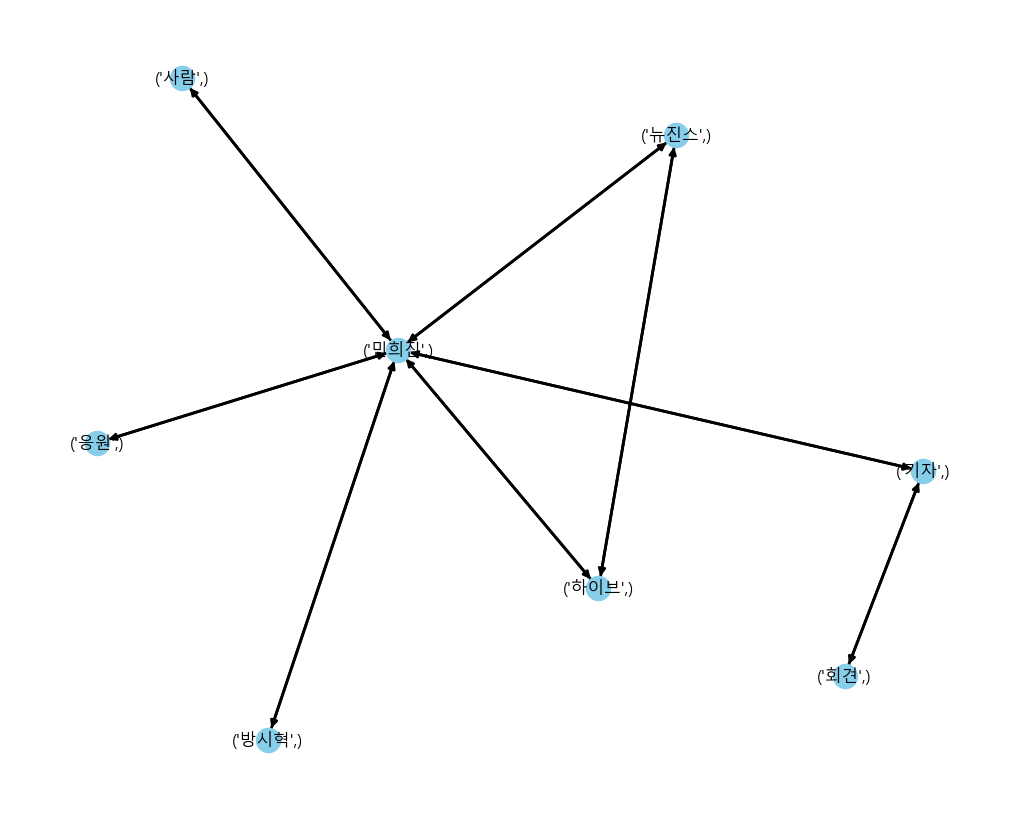

In [161]:
G = nx.DiGraph()

for row in results.itertuples():
    antecedents = tuple(row.antecedents)
    consequents = tuple(row.consequents)

    G.add_edge(antecedents, consequents, weight=row.lift)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
pos = nx.spring_layout(G, k=2)
plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='skyblue',
    # edge_color=edge_weights,
    width=2.0,
    edge_cmap=plt.cm.Blues,
    font_family='Malgun Gothic'
)
plt.show()